# ISGRI Calibration Reconstruction Invariance

## Purpose of this section

(sec:purpose-general)=
### General considerations

Measurement consists in instrument converting some true physical $Model$ in some $Observation$. Recovering the $Model$ from $Observation$ is the **inverse problem**. 

It is sometimes suggested that inverse problem should be ideally addressed with forward folding model and comparing the result with raw data. Mathematical elegance of this approach gave rise to considerable following.
It is, however, not always realistically feasible.
Instead, $Observation$ is reduced and **reconstructed** at least part of the way before comparing with $Model$ folded with $Response$.

```{note}
I try to show that if applied correctly $Reconstruction$ is a perfectly valid process, only possibly discarding some (often irrelevant) information in the data. 
I will also show what can be the optimization criteria for selecting $Reconstruction$ .
```

It is interesting to note that many Machine Learning algorithms take form of a $Reconstruction$.

It is curious that eventually inferred $Model$ may be treated as a resconstructed $Observation$ by a higher order **inverse problem**. For example, if $Model$ recovered in the inverse problem is spectral model, but further modelling is done to apply physical model. Such a hierarichal process is often used to reduce needed resources but also to developed structured understanding of the problem. 

### Frequent confusion about ISGRI 

ISGRI uses particular assumptions for the $Reconstruction$ processes, different from those used in other instruments. These assumptions are largely motivated by the coded mask process and particularly substantial variability if ISGRI detector comparing to other similar detectors.
This situation causes regular confusion about the meaning of ISGRI reconstructed ("normalized") count rate, applicable statistical models, meaning of response and efficiency.

Here, after a brief introduction in terminology, I explain the entire ISGRI reconstruction process, as motivated by historical practice and as defined in OSA11.

```{note}
Particular questions which often come up are:

* What is the meaning of ISGRI count rates? How are they related to detector count rates? ([](sec:isgri-recon))
* What statisical model is applicable to ISGRI count rates?
* How to interpret ISGRI data in very small time and energy bins? 
* Is it possible to combine ISGRI spectra in small bins?
* What is ISGRI Efficiency, how is it different from other notions of detector/detection efficiency?
* Is ISGRI ARF variable? Should it be? What does it mean?
* What is ISGRI effective area, is it the same as ISGRI ARF?
* What spectrum is assumed in computing ISGRI Efficiency and what is the effect of this choice?
* What spectrum is assumed in LUT2 generation and what is the effect of this choice? What is the difference between non-determenistic LUT2 in OSA10 and deterministic in OSA11?
```

#TODO: problems of propagating efficiency
#TODO stable vs unstable
#TODO other instruments


(sec:theory)=
## ISGRI observation space and general reconstruction basics


$Observation$ (e.g. `ISGRI` spectral histograms) can be represented as transformation of some true $Model$ with $Response$:

$$
Observation~=~ Response \times Model
$$

Note that $Observation$ does not belong to the same space as $Model$. For example, when $Model$ is vectors of flux in incident photon energy bins, $Observation$ is detected 
counts in detector channels. 

For `ISGRI`, each pixel detector channels are biparametric, described by $\mathrm{ISGRI\_PHA}$ and $\mathrm{ISGRI\_RT}$ integers. `ISGRI` stores channel values for each event, but it is often useful to consider histogram of these detected values.

$$
CountSpectrum\left[\mathrm{ISGRI\_PHA,~ISGRI\_RT}\right] = \sum_{Energy, Coordinate}~Response\left[\mathrm{ISGRI\_PHA,~ISGRI\_RT},~\mathrm{Energy, Coordinate}\right] \times ModelFlux\left[\mathrm{Energy, Coordinate}\right]
$$

Where $CountSpectrum$ is histogram from channel values as directly returned by the pixels. 

Here we assume that $CountSpectrum$ is additive. This assumption is almost always valid, except when dead time effects due to source rate are relevant. The latter occurred, for example, in an extremely high-flux short bursts, and can be somewhat easily treated. To simplify the notation we disregard this possibility in what follows.

This equation is valid for a single pixel at single moment of time. All pixels differ, and also evolve, in long term as well as in short disruptions of several different kinds.
Were we assume that $ModelFlux$ is constant in time, and there is only one source in the sky; this is reasonable since here we are primarily concerned with spectral reconstruction (see however the [](sec:nomex)). 
So it is almost always necessary to conside that

$$
CountSpectrum\left[\mathrm{Channel}\right] = \sum_{Energy}~Response\left[\mathrm{Channel},~\mathrm{Energy}\right] \times ModelFlux\left[\mathrm{Energy}\right]
$$

where

$$
\mathrm{Channel} = \left[\mathrm{ISGRI\_PHA,~ISGRI\_RT,~ISGRI\_PIXEL,~Time}\right]
$$


It means that `ISGRI` spectra are, in principle, always 4-dimensional. `ISGRI` is not unique in this, many other instruments/telescopes are in a similar situation, though not many have an extra dimension fo pulse properties (the rise time).

When defined in this way, the entire transformation from the incident flux to observation is contained in the response function $Response$.

A 4-dimensional $Observation$ space becomes quite large, and $Response$ is even larger. Assuming that detector variations in $\mathrm{Time}$ are at most at 100~second timescale, there are $2048 \times 256 \times 128 \times 128 \times 24 \times 3600 / 100$ there are in total about $10^{13}$ bins in a $CountSpectrum$. There are only $10^{8}$ `ISGRI` photons per day, so this spectrum is mostly empty. Without changing the essence of the approach, it is more feasible to compare time-tagged events. In this case, it is still necessary to compute per-event response, accounting for all 4 detector variables. This approach extracts the most out of ISGRI data, but is quite computationally expensive. It was exploited in {cite:t}`mereghettiINTEGRALDiscoveryBurst2020` for about 1-second long event with very fine time structure. It does not currently appear very realistic to apply this method to multi-day observations. And even it if was feasible, it would not bring any benefits, since major uncertainty in ISGRI is associated with response uncertainties.

Luckily, since the $Model$ space is only 1-dimensional (for a single constant source) it is possible, with only some loss of information, to reduce the size of the observation space to 1 dimension, $CountSpectrum$ in some reconstructed channel, $\mathrm{ISGRI\_ENERGY}$. 

The transformation can be done with 

$$
CountSpectrumRec\left[\mathrm{ISGRI\_ENERGY}\right] = \sum_{\mathrm{Channel}}~Reconstruction\left[\mathrm{ISGRI\_ENERGY, Channel}\right] \times CountSpectrum\left[\mathrm{Channel}\right]
$$

in order to preserve the relation between data and model

$$
CountSpectrumRec\left[\mathrm{ISGRI\_ENERGY}\right] = \sum_{Energy}~Response\left[\mathrm{ISGRI\_ENERGY},~\mathrm{Energy}\right] \times ModelFlux\left[\mathrm{Energy}\right]
$$

response should satisfy 

$$
ResponseRec\left[\mathrm{ISGRI\_ENERGY, Energy}\right] = \sum_{\mathrm{Channel}}~Reconstruction\left[\mathrm{ISGRI\_ENERGY, Channel}\right] \times Response\left[\mathrm{Channel, Energy}\right]
$$


```{note}
Note that all this is valid for any $Reconstruction$ function. Using some peculiar $Reconstruction$ it is possible to build a very unusual but still valid channel spectra in $\mathrm{ISGRI\_ENERGY}$ which will yeild accurate (even if possibly not very precise) $Model$. 

This constitutes **considerable invariance of accurate inferrence on $Reconstruction$ process**

In practice, reconstruction segmented and is selected to:
* reduce information loss (e.g. improve resolution - reduce overlap between useful representations of interesting variables in the reconstructed space TODO) 
* fit scientific intuition
* reduce dependence on systematic uncertainties

All this is only relevant when some reconstruction is applied, i.e. when complete forward folding is not possible (see e.g. [here](threeML) for complete forward process).
```

For example degenerate $Reconstruction$ which discards any information about other variables but $\mathrm{ISGRI\_PHA}$ will produce not an unreasonable spectrum. This spectrum will have rather washed-out (broadened) spectral features and will evolve with time even for a constant source. Appropriate response would have to be incorporate in a suitable response.

In `ISGRI`, $ChannelReconstruction$ has two kinds of anomalous properties:
* $\mathrm{ISGRI\_ENERGY}$ is a monotonous function of $\mathrm{ISGRI\_PHA}$ only below some critical $\mathrm{ISGRI\_RT}_{reversal}$. This is because high-depth high-energy interactions produce high RT and low PHA, and PHA may be come lower than that of a low-energy interaction (which reach large RT due to RT resolution, without out much change in PHA).
* absorbtion edges at 30 keV

In both cases, to avoid using irregular function, it is sufficient to choose simpler reconstrciton.
It may seem that these anomalies, especially that at 30 keV, could help in characterizing the instrument. Unfortunately, the expected features in the data are quite `TODO: describe`

```{warning}
Note that even with some motivated $Reconstruction$, the reconstructed channel $\mathrm{ISGRI\_ENERGY}$ is very different from incident photon energy. 
In principle, the reconstruction may be selected so that $\mathrm{ISGRI\_ENERGY}$ approximates incident $\mathrm{Energy}$. This would correspond to some optimal $Reconstruction_{optimal}$.
```

While any $Reconstruction$ discards information, some of them will provide more information than the other. It is, therefore, possible to pick optimal maximally-informative $Reconstruction_{optimal}$ (see below).

We are interested in particular [\[2\]]() case of this transformation, which enables relation between original and reconstructed channels:

$$
\mathrm{ISGRI\_ENERGY} = ChannelReconstruction\left[\mathrm{Channel}\right] \\
$$


If $CountSpectrum$ is an arbitrary function of $Channel$, some $ChannelReconstruction$ may be incompatible with some single-valued $Reconstruction$ functions. For example, if   it is required that function value is preserved across the transformation

$$
CountSpectrumRec\left[ChannelReconstruction\left[\mathrm{Channel}\right]\right] = CountSpectrum\left[\mathrm{Channel}\right]
$$


Clearly, if $CountSpectrum$ changes as function of $\mathrm{Channel}$ along tranjectories of constant $\mathrm{ISGRI\_ENERGY}$, single-valued $CountSpectrumRec\left[\mathrm{ISGRI\_ENERGY}\right]$ can not exist.

On the other hand, if $CountSpectrum$ is the density on $\mathrm{Channel}$ space, it will satisfy

$$
CountSpectrumRec\left[ChannelReconstruction\left[\mathrm{Channel}\right]\right] \times ChannelReconstruction'\left[\mathrm{Channel}\right] = CountSpectrum\left[\mathrm{Channel}\right]
$$

This equation can be solved together with [the one above](fig) to derive $CountSpectrumRec$, in some cases. `TODO: elaborate on the condition required for this`
Note, however, that **this condition is intentionally not satisfied in `ISGRI`**.

(sec:isgri-recon)=
## Structure of ISGRI $Reconstruction$

(here and everywhere in this note, channel variable names correspond to those used in `OSA`, bold, etc TODO)


As described above, there is a lot if freedom in how the reconstruction is done, as long as the response is generate accordingly. It might be desirable to follow some optimalily and regularily conditions, and we will apply in part at the end of this note.

Historically, the reconstruction process in `ISGRI` was intented ad-hoc following scietific intuition. The result is not far from optimal.
It consists of multiple stages.

$$
\mathrm{ISGRI\_ENERGY} = (\mathrm{LUT2} \circ \mathrm{LUT1}) \left[\mathrm{Channel}\right]\\
$$
$$
CountSpectrumRec = (\mathrm{NOMEX} \circ \mathrm{Imaging} \circ \mathrm{Uniformity} \circ \mathrm{PixelEfficiency}) \left[CountSpectrum\right]
$$

Below each component is described briefly, clarifying which dimensions they discard, and what optimizations are selected:

### `LUT1` reconstruction


$$
LUT1\left[Time\right]: \mathrm{ISGRI\_PHA , ISGRI\_PIXEL}  \Rightarrow  \mathrm{ISGRI\_PHA1},  \mathrm{ISGRI\_RISE} \Rightarrow \mathrm{ISGRI\_RT}
$$

* `LUT1` discards $\mathrm{ISGRI\_PIXEL}$ dimension
* It uses detector temperature, which is a function of `Time`.
* The transformation is optimizing energy resolution. It does not explicitly depend on time (except for the temperature). 
* Resulting $\mathrm{ISGRI\_PHA1}$ values are close to those average $\mathrm{ISGRI\_PHA}$.

### `LUT2` reconstruction

$$
LUT2\left[Time\right]: \mathrm{ISGRI\_PHA1, ISGRI\_RT}  \Rightarrow  \mathrm{ISGRI\_ENERGY}
$$

`LUT2` discards $\mathrm{ISGRI\_RT}$ dimension (since `OSA11`, it is a function function of `Time`), and optimizes to:
* Iprove energy resolution
* Make response have a strong diagonal component: photopeak interactions reconstruct $\mathrm{ISGRI\_ENERGY}$ close to incident `Energy` 

Before `OSA11`, `LUT2` did not depend on time. Instead, a different correction was applied before `LUT2`.

(sec:pixelefficiency)=
### `PixelEffieciency` reconstruction

$$
Imaging: CountSpectrumRec\left[\mathrm{ISGRI\_PIXEL, Energy}\right]  \Rightarrow  CountSpectrumRec1\left[\mathrm{ISGRI\_PIXEL, Energy}\right]
$$


Each `ISGRI` pixel has a low-PHA threshold. Most the the pixels have threshold settings around 15. Specific $\mathrm{ISGRI\_PHA}$ threshold value is different, but made to match $\mathrm{ISGRI\_PHA}$ of about 15 keV at the early mission. 

The threshold is not sharp, it a smooth function, with width similar to the resolution. 
Pixel settings change slightly every orbit.

`TODO:` In principle, LT in `PHA` is nearly constant, to determine why


The function depends on the pixel setting and pixel type (there are two pixel types). Pixel setting and kind are the best tracers of divergence between pixel response. ![pic here]()

There is no straightforward way to predict this function preciesly, while it is also necessary, since low-energy efficiency is the single strongest factor in the entire spectral reconstruction. It also affects imaging quality at the lowest energies.


```{note}
`PixelEffieciency` simultaneously affects spectral and imaging performance, which might compete. Before OSA11, spectral reconstruction from was rather theoretical and approximate, and time-dependent $Response$ was accounting for spectral variations. 

With OSA11, `PixelEffieciency` is calibrated in-flight with sufficient precision to avoid the need for modifications in ARF to compensate for `PixelEffieciency` incompleteless. 
`TODO: there is stil something unclear `
```

Further imaging-specific adjustments to `PixelEfficiency` might be necessary. Though right now, it seems that imaging performance is the same as `OSA10`, meaning that the difference is irrelevant. Instead, imaging improved with a dedicated additional, per-orbit efficiency model derived from detailed sky models [as done here](https://github.com/volodymyrss/dda-deconstruction). See also `sextractor`-based reconstruction ISGRI imaging in [there]().

```{warning}
`PixelEfficiency` divides $CountSpectrum$ by some theoretical or calibrated function, with no change to the channel variable.
 t this time, reconstructed count rate $CountSpectrumRec1$ no more has the meaning of number of counts in some channel rate. Imaging and NOMEX corrections futher exhaugurate this condition. Other X-ray instruments typically choose to avoid this sort of transformation, since it complicates intepretation. But in coded-mask instruments, with strongly overlapping `PSF`, it can be useful.
```

`PixelEfficiency` is selected to make sure that:
* $CountSpectrumRec1$ of a source with constant flux does not change very much with mission life time
* `PIF` are compatible with what would be expected from if all pixels were identical (note interplay with NOMEX)

It would be possible to rely more on `PixelEfficiency` even before `OSA11`. But before several reconstruction troubles were addressed which time-dependent `LUT2`, it was very hard to model reasonably-structured efficiency.

### `Uniformity` reconstruction

Uniformity is equivalent to another component of `PixelEffieciency`. It is currently set to all unity values (i.e. disabled)

(sec:imaging)=
### `Imaging` reconstruction

$$
Imaging: CountSpectrumRec1\left[\mathrm{ISGRI\_PIXEL, Energy}\right]  \Rightarrow  CountSpectrumRec2\left[\mathrm{SkySource, Energy}\right]
$$

This reconstruction converts functions of detector pixel into functions of sky locations. Position-dependent factors are introduced at this time, so that:

* $CountSpectrumRec2$ represents count rate the same source if it was for on-axis with all-open mask and no NOMEX. TODO

Due to energy-dependence of `Imaging`, it needs to use mostly incident `Energy` values, for example to compute opacity of mask elements, shield, etc. But these values are not known at this stage. So instead, `Imaging` simply uses $\mathrm{ISGRI\_ENERGY}$. For example, photon with $\mathrm{Energy}$ = 200 keV will no trouble getting through the shield, but it is most likely to deposit lower energy, e.g. $\mathrm{ISGRI\_ENERGY}$ == 30 keV, and the opacity used for this photon will be much higher than was actually experienced.

Luckily, this is usually sufficient, since energy dependence is not large at low energy (where reconstruction precision requirements are the highest). Also since most sources are soft, for $\mathrm{ISGRI\_ENERGY}$ = 30 keV, only a minority of photos will have much higher incident energy, and they can be disregarded in the reconstruction. Similarly, for $\mathrm{ISGRI\_ENERGY}$ = 200 keV, most photons will come from $\mathrm{Energy}$ = 200 keV. I.e. for soft sources, average $\mathrm{ISGRI\_ENERGY}$ in a bin is a good indicator of average $\mathrm{Energy}$. For particularly hard sources, this might not be the case.

TODO: imaging quality note from PIF homogenuoity

(sec:nomex)=
### `NOMEX` reconstruction

$$
Imaging: CountSpectrumRec2\left[\mathrm{ISGRI\_PIXEL, Energy}\right]  \Rightarrow  CountSpectrumRec\left[\mathrm{SkySource, Energy}\right]
$$

Nomex is a structure supporting the mask. Its opacity is especially difficult to model, and was calibrated in-flight so that:
* Sources at different locations with respect to the satellite have the same reconstructed count rate
* Average count rate is derived from what was calibrated on-ground, and is difficult to verify.

In principle, it is part of `Imaging`, and subject to the same issues, just on a larger scale. Average transparency of NOMEX at 30 keV is about 50% and 20% at 100~keV.

### Summary 

All the above corrections aim to make `Response` as constant as possible. In this process, simple and conventional meaning of the `CountSpectrum` as event histogram is lost. Resulting `CountSpectrumRec` spectrum becomes almost constant, but additional freedom in energy-dependent (but not time-dependent) normalization remains. 
This normalization is selected to satisfy some additional conditions, which are poorly satisfied due to historical reasons. In any case, these conditions are difficult to interpret for a regular user.

The only correction which has to remain in Response, is resolution. Indeed it is not possible to fully reconstruct-out broading of the spectrum (it is possible, but not advisable, to make all spectra equally broead and keep the response identical throughout the mission).


````{panels}
CountSpectrum Reconstruction
^^^
```{mermaid}
graph TD
    CountSpectrum[Raw Event Rate]  --> |PixelEfficiency/ii_shadow_build| ChannelRec1[CountSpectrumRec1];
    ChannelRec1[CountSpectrumRec1]  --> |Imaging/NOMEX| ChannelRec2[CountSpectrumRec];
```
---

Channel Reconstruction
^^^
```{mermaid}
graph TD
    Channel[ISGRI_PHA, ISGRI_RT]  --> |LUT1, temperature| ChannelRec1[ISGRI_PHA1];   
    ChannelRec1[ISGRI_PHA1, ISGRI_RT1] --> |drift/OSA10| ChannelRec2[ISGRI_PHA2, ISGRI_PI];  
    ChannelRec2[ISGRI_PHA2, ISGRI_PI] --> |LUT2/OSA10| ChannelRec[ISGRI_ENERGY, ISGRI_PI];  
    ChannelRec1[ISGRI_PHA1, ISGRI_RT1] --> |LUT2/OSA11| ChannelRec[ISGRI_ENERGY, ISGRI_PI];  
```
````

## Effective area

`Effective area` is commonly understood as ratio of **detected count rate** for the given instrument, to the incident **photon flux**. Clearly this assertion depends on assumption of detector being linear.

For some set of sky locations, energies, and time moments:

$$
EffectiveArea = \frac{\sum_{\mathrm{Energy},~\mathrm{SkySource},~\mathrm{Time}} CountSpectrum}{\sum_{\mathrm{Energy},~\mathrm{SkySource},~\mathrm{Time}} Model}
$$


But which count rate should be used in this ratio? It seems natural to use the true detector count rate ($CountSpectrum$ as introduced [](sec:theory)). For ISGRI, $EffectiveArea$ define in this way would depend strongly on sky location, time and energy. It would have been possible to generate this $Response$ for every given observation, but due to strong correlation of sources in coded mask process, responses for all sources would have to be generated in each observation, and fitted all at once.
Perhaps because of how variable it is, this quantity is rarely considered for ISGRI.


As described in [](sec:isgri-recon), ISGRI relies on extensive $Reconstruction$ to produce certain $CountSpectrumRec$, also known as **normalized count rate**, for equivalent on-axis source, for non-lossy pixels.
This $CountSpectrumRec$ is written in ISGRI spectra, light curves, and image "flux" tables.
Hence it is possible to produce $EffectiveAreaRec$ for 


```{warning}
$EffectiveAreaRec$ which corresponds to user-visible $CountSpectrumRec$ is hardly a good measure of ISGRI instrument performance, since it is concealing hidden ISGRI efficiencies, accounted-for in the $Reconstruction$.
```

```{warning}
Commonly used `xspec` {cite:p}`1996ASPC..101...17A` has [plot efficien](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node112.html) command which is used to:

> Plot the total response efficiency versus incident photon energy


This `response efficiency` corresponds to $EffectiveAreaRec$ in ISGRI. 

Instead, in {term}`ISGRI`, term $Efficiency$ is used to describe multiplicative $Reconstruction$ component:  the function by which the $CountSpectrum$ is divided (see [](sec:pixelefficiency) for details)
This efficiency is meant to represent chance of photon interacting in ISGRI pixel to be converted to ISGRI count (for particular event class, i.e. `S1` scientific events). I.e. it is a **photon detection efficiency**, not taking into account incident photon absorption in NOMEX or other structures, and the chance of the photon to interract in the pixel.  These affects are instead contained in the $Response$.
```

```{note}
Many instruments, including ISGRI before OSA10, adjust Effective area (in ARF) during in-flight calibration. Since "true" ARF is variable, the result is not necessarily strange.
Since it is hard to deal with raw counts in ISGRI, and complex reconstruction has been always used, it might make sense to absorb as much variable detector properties as possible into efficiency, while let $Response$ (and hence ARF) to account for particle transport (including detector geometry). Notably, it is not possible to include resolution degradation in reconstruciton, which is why response will always remain variable. It is possible to artifically make effective area constant but absorbing resolution-induces efficiency effects in reconstruction, but this makes little sense. 
Note that in ISGRI, due to complex interplay of low threshold, detector polarization, resolution, and multiple event suppression, these efficiency effects spread up to 100 keV (see [](sec:multiple-events)).
```

```{note}
Sometimes, it is worth considering **source detection efficiency**. This concept depends on the entire complete $Response$ and also $Background$ and is quite different from what is discussed in the present document.
```

## Vigentting in ISGRI

`Vignetting` is loss of effective area for off-axis observations. ISGRI experiences `vignetting` already in fully-coded FoV (due to NOMEX, [](sec:nomex)) but especially in partially-coded FoV (see [](sec:imaging).
ISGRI `Vignetting` is completely hidden in $Reconstruction$ process.


(sec:exposure)=
## Effective Exposure in ISGRI

* `TELAPSE`: 
* `ONTIME`: 
* `EXPOSURE`

#TODO: dead time


(sec:full-recon)=
## Full, no forward-folding $Reconstruction$: count rate in `Crabs` and as proxy for flux

There is a common way to derive approximate source flux by comparing source count rate with count rate of Crab, and assuming that the flux scales linearly with count rate.

In terms of the description in [](sec:theory), this process corresponds to producing $ReconstructionComplete$ so that $ResponceComplete$ is close to unitary, and $CountSpectrumRecComplete$ is numerically close to flux is the selected units.

In ISGRI, $CountSpectrumRec$ corresponds to approximately constant $ResponseRec$. If it is not constant, $ReconstructionComplete$ can be designed to be valid in certain time range.

In order to set limit in some $\mathrm{Energy}$ range, the best sensitivity may be achieved by avoiding any selection on $\mathrm{Channel}$. 
E.g. to estimate 20 - 40 keV flux, there is no needto select count rate in 20 - 40 (channel)keV. But this is almost never done.

Instead, it is thought to be natural to select count rate in certain optimal $\mathrm{Channel}$ range. Correspondence between (channel)keV and keV is always inexact, but there is a natural correspondance, applicable for moderadly dispersive instrument like {term}`ISGRI` and somewhat soft spectra.

It can be shown that this selection minimizes dependence on the source model (TODO:to show?).


## From $Response$ and $Reconstruction$ uncertainty to $Model$ uncertainty

Measurement of $Model$ is, in real situations, always uncertain. Much of the uncertainty is due to $Observation$ being realization of some random process. This is so-called "statistical" uncertainty.
In addition, $Response$ is often also uncertain. $Response$ uncertainty can be included in the reconstruction and inverse problem solving in different ways.

### Reconstruction uncertainty

Reconstruction is usually a deterministic process. Nevertheless, uncertainty is often included in the $CountSpectrumRec$ by adding `systematic error`. `Systematic error` represents an assumption that $CountSpectrumRec$ is affected by some unknown random process, typically assumed to be gaussian, which depends on unknown detector properties or other factors.

`Systematic error` can be added in $CountSpectrumRec$ of {term}`ISGRI` as a normalization uncertainty in each bin. This approach does not allow to include uncertainty, for example, on energy reconstruction or resolution.
`xspec` allows to add `systematic fraction` as constant fraction of flux, which is even more restrictive.

When the entire counts-to-model process is viewed as $Reconstruction$ (as in [](sec:full-recon) and [](sec:purpose-general)), the entire uncertainty is in the reconstruction uncertinainty.

### Response uncertainty

Response uncertainty can be contained in nuissance parameters, if the response is fitted together with source. 
Response model based on [threeML]() exists for [ISGRI](https://github.com/volodymyrss/integral-response-model.git).
Uncertainty in the response model response model has an advantage of providing handle on particular, motivated by components.

With ISGRI Response uncertainty, it is possible to expess lack of knowledge in a way which is not achievable with simple `systematic error`. The latter is limited to uncertainity of count spectrum of normalization, while ISGRI uncertainty is largely in energy reconstruction and resolution.
TODO: what does misuse mean?

# Practice and example of Calibration Invariance

below we show process of selecting additional optimization of the reconstruction 

TODO: it's useful to stack spectra

TODO: 
* lut3d to physicality smooth
* efficiency as expect, response, "true" ISGRI efficiency

lt in pha, model and show

called effi in several place

imaging effi, model and show separately

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d as g1d
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from matplotlib import cm
from astropy.io import fits
import importlib


In [108]:
import sys
sys.path.insert(0, '..')
import iconfig
importlib.reload(iconfig)
ic_base = iconfig.settings.rep_base_prod

fits.open(ic_base + '/ic/ibis/mod/isgr_effi_mod_0002.fits')[1].data

import nomex
importlib.reload(nomex)

/isdc/arc/rev_3


<module 'nomex' from '/home/savchenk/integral-ibis-isgri-le-response/book/../nomex.py'>

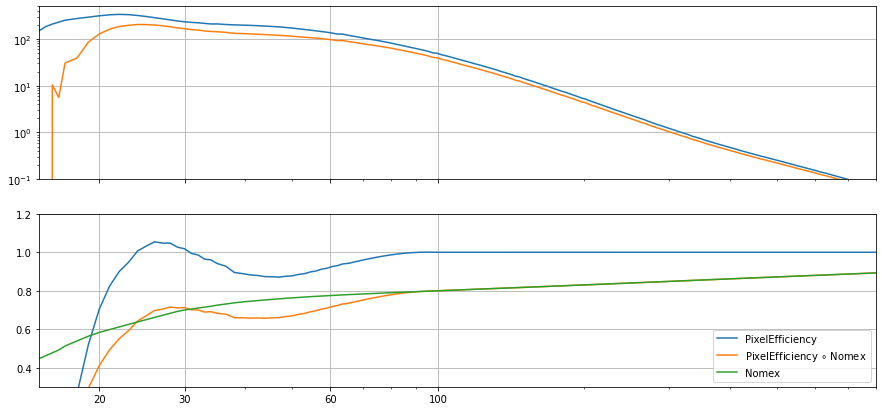

In [109]:
import importlib
from astropy.io import fits
import numpy as np
import sys
import os
sys.path.insert(0, os.path.join(os.getenv('HOME'), 'ogip'))

import ogip
import ogip.tools
import ogip.spec

ic_base = iconfig.settings.ic_base

effi = fits.open(ic_base + '/ic/ibis/mod/isgr_effc_mod_0235.fits')[1].data[11]['EFFICIENCY']
ebds = fits.open(ic_base + '/ic/ibis/rsp/isgr_ebds_mod_0001.fits')[1].data
matrix = fits.open(ic_base + '/ic/ibis/rsp/isgr_rmf_rsp_0235.fits')['ISGR-RMF.-RSP'].data
ce1, ce2 = ebds['E_MIN'], ebds['E_MAX']
e1, e2 = matrix['ENERG_LO'], matrix['ENERG_HI']
rmf = ogip.spec.RMF.from_arrays(e1, e2, np.stack(matrix['MATRIX']), ce1, ce2)

nomex_norm = nomex.read_nomex_norm(ebins=(ce1, ce2))

ogip.spec.PHAI.from_arrays(
    exposure=1000,
    rate=np.ones_like(ce1),
    stat_err=np.ones_like(ce1),
)

rate = ogip.tools.convolve(
    ogip.tools.crab_ph_cm2_s_kev,
    rmf,
)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7), sharex=True)

ax1.plot(
    ce1, rate/(ce2-ce1) * ce1,
    label='CountSpectrumRec'
)

ax1.plot(
    ce1, rate/(ce2-ce1) * effi * nomex_norm['norm'] * ce1,
    label='CountSpectrumRec2'
)

ax2.plot(
    ce1, effi,
    label=r'PixelEfficiency'
)

ax2.plot(
    ce1, effi * nomex_norm['norm'],
    label=r'PixelEfficiency $\circ$ Nomex'
)

ax2.plot(
    ce1, nomex_norm['norm'],
    label=r'Nomex'
)


ax1.loglog()
ax1.set_ylim([0.1, 500])
ax2.set_ylim([0.3, 1.2])
ax1.grid()
ax2.grid()

ticks = list(ax2.get_xticks()) + [20, 30, 60]
ax2.set_xticks(ticks)
ax2.set_xticklabels([f"{t:.4g}" for t in ax2.get_xticks()]) #, rotation='vertical')
ax1.set_xlim([15, 800])

plt.legend()

/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0031.fits
5.0 2200
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0032.fits
5.0 2200
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0033.fits
5.0 2200
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0153.fits
16.967052 2466
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0163.fits
16.92437 2466
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0176.fits
16.869368 2466
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0177.fits
16.865158 2466
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0180.fits
16.852556 2466
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0182.fits
16.844173 2466
/unsaved/astro/savchenk/osa11/ic-collection/beta/ic/ibis/rsp/isgr_rmf_rsp_0191.fits
16.806597 2466
/unsaved/astro/savchenk/osa11

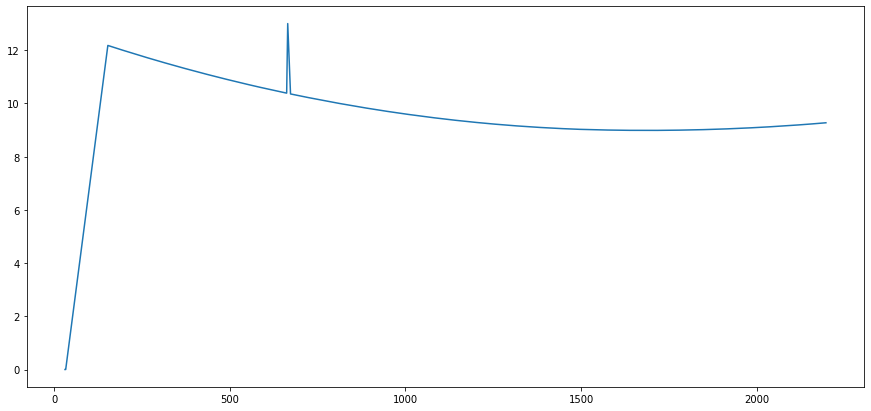

In [206]:
from astropy.time import Time

import glob
import pandas as pd
from pathlib import Path

plt.figure(figsize=(15,7))

byrev = []

for rsp_fn in sorted(glob.glob(str(Path(iconfig.settings.ic_base) / 'ic/ibis/rsp/isgr_rmf_rsp_*.fits'))):
    # if '5.fits' not in rsp_fn: continue
    print(rsp_fn)

    rev = int(rsp_fn.split("_")[-1].split(".")[0])

    f_rsp = fits.open(rsp_fn)

    #if Time(f_rsp[1].header['DATE']) < Time('2021-10-01'): continue


    # plt.plot(
    #      f_rsp[1].data['ENERG_LO']
    # )

    print(f_rsp[1].data['ENERG_LO'][10], len(f_rsp[1].data['ENERG_LO']))

    # plt.plot(
    #     f_rsp[1].data['ENERG_LO'],
    #     np.stack(f_rsp[1].data['MATRIX']).sum(1)
    # )

    # plt.semilogx()

    byrev.append(dict(
        rev=rev, 
        fn=rsp_fn,
        vstart=f_rsp[1].header['VSTART'],
        version=f_rsp[1].header['VERSION'],
        e0=f_rsp[1].data['ENERG_LO'][0]))

byrev = pd.DataFrame(byrev)

plt.plot(
    byrev.rev,
    byrev.e0,
)


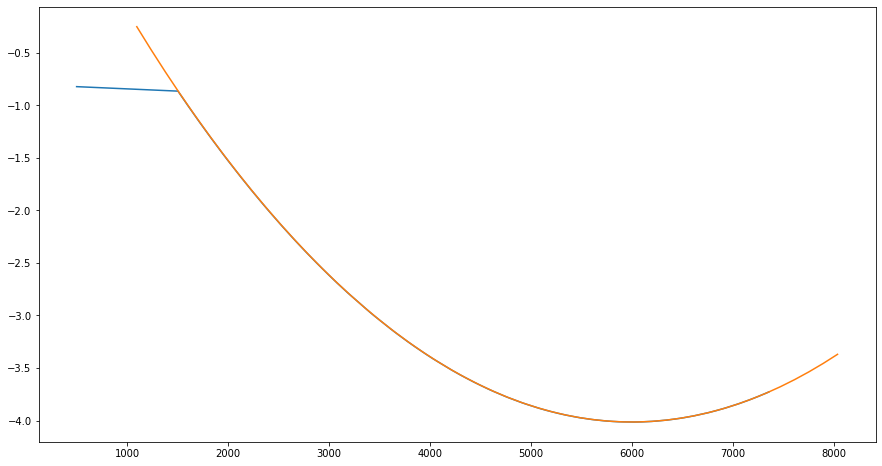

In [194]:
import produce_e_morph

plt.figure(figsize=(15,8))

plt.plot(
    byrev.vstart,
    byrev.e0 - 13,
)

i = np.linspace(
    Time("2003-01-01").mjd - 51544,
    Time("2022-01-01").mjd - 51544
    )

eref = 15

plt.plot(
    i,
    [produce_e_morph.produce_e_morph(_i, _i+1)[0](eref) - eref for _i in i],
)


In [221]:
ref_fn = byrev.loc[byrev.e0.argmax()].fn
ref_rsp_f = fits.open(ref_fn)

matrix = ref_rsp_f['ISGR-RMF.-RSP'].data
ce1, ce2 = ebds['E_MIN'], ebds['E_MAX']
ref_e1, ref_e2 = matrix['ENERG_LO'], matrix['ENERG_HI']

ref_e1, ref_e2

array([  13.    ,   13.4787,   13.9574, ..., 1192.0381, 1192.5168,
       1192.9955], dtype=float32)

[]

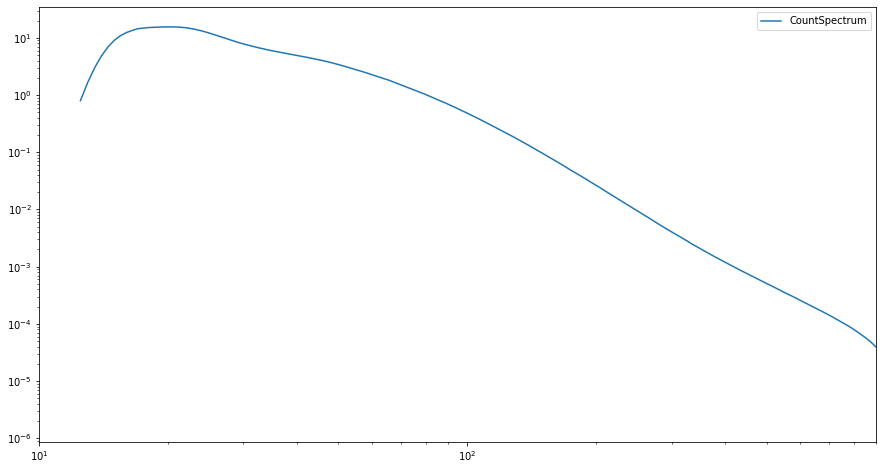

In [223]:
rsp_f = fits.open(byrev.iloc[50]['fn'])
matrix = rsp_f['ISGR-RMF.-RSP'].data
ce1, ce2 = ebds['E_MIN'], ebds['E_MAX']
e1, e2 = matrix['ENERG_LO'], matrix['ENERG_HI']
rmf = ogip.spec.RMF.from_arrays(e1, e2, np.stack(matrix['MATRIX']), ce1, ce2)

rate = ogip.tools.convolve(
    ogip.tools.crab_ph_cm2_s_kev,
    rmf,
)

plt.figure(figsize=(15, 8))

plt.plot(
    ce1, 
    rate/(ce2-ce1),
    label='CountSpectrum'
)

# need to restore else heasoft summing does not work well across large time range. TODO: what will it even do? first rsp bins?

# it does not matter how it's transformed as long as response is accordingly. 
# but need to preserve counts evolution
# new effi from morph

# here need to imitate what will OSA produce when binning and reconstructing
# def emorph_rate(ce1, ce2, rate, emorph):
#     edges = np.concatenate([ce1, ce2[-1]])
#     cumrate = np.cumsum(rate)
#     cumrate_emorph = interp1d(
#         emorph(edges),
#         cumrate,
#     )(edges)
# need to adapt morph until response is central

# em_rate = e

# plt.plot(
#     emorph(ce1), 
#     em_rate/(ce2-ce1) * effi * nomex_norm['norm'],
#     label='CountSpectrum modified'
# )

plt.legend()

plt.xlim([10, 900])

plt.loglog()

#TODO: compute spectrum with modiied RSP. compute spectrum with non-modified RSP. several time moments

effi imaging description



## Misreconstruction

## Changing from one reconstruction to another: relation between $ChannelReconstruction$ and $Reconstruction$: 






Relation between $ChannelReconstruction$ and $Reconstruction$ 

$$
TODO
$$



## Optimal transfomration

In [13]:
# TODO: measure or mimick gain from HE line alone, and from LE line alone. find which one mismatches

# TODO:
# * reconstruct with det
# * reconstruct with det and morph

# TODO: 
# reconstruct effi
# reconstruct lut2
# reconstruct rsp



## Differences in reconstruction between OSA10 and OSA11

### LUT2

### Efficency and ARF

As described above.

## Possibility of Complete forward folding in ISGRI

It is **theoretially simple**, and most **information-saving** to avoid any reconstruction. 

This means that complete multi-dimensional $Response$ (see [](sec:theory)) would be required, and would have to be combined with complete sky and spectral $Model$ to produce preducted raw detector counts.

It is not possible to produce complete matrix in this way, but it would be possible to reverse ISGRI reconstruction (see [](sec:isgri-recon)) to produce $Model$ count rate for every detected count. Sky model would have to include all sources with their spectra. This approach would be similar to that used in Fermi/LAT.

With full forward folding, binning data would not possible, since binned histogram with in all necessary dimensions would be very large and mostly empty (see [](sec:isgri-recon)). Single-event treatment would be therefore be not only most advisable but also most efficient.

The primary challenge in this case would be sheer number of photons. ISGRI count rate is about 100 times larger than that of Fermi/LAT (800 vs 8 events/s).
Given more recently availlable computing power, it might be achievable.

Forward folding would help to:
* avoid consequences of using of $\mathrm{ISGRI_ENERGY}$ instead of $\mathrm{Energy}$ in imaging (see [](sec:imaging)). The effect might be detectable for hard-spectra sources.
* take into account spectral-dependency of LUT2, perhaps (marginally?) improving energy resolution. If there is a hidden variable explaining unexpected resolution loss, it might be recoverable in this way.
* take into account efficiency uncertainty, for much better imaging



(sec:multiple-events)=
## Multiple events
